# 2. Feature Engineering

Second attempt at building a model to predict house prices. 

In [1]:
import os
import platform
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Check which platform is running the notebook
if platform.system() == 'Windows':
    PROJECT_PATH = "\\".join(os.getcwd().split('\\')[:-1])
else:
    # Assuming a Unix based platform
    PROJECT_PATH = "/".join(os.getcwd().split('/')[:-1])

DATA_PATH = os.path.join(PROJECT_PATH, 'data')
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train.csv')

# Load the training dataset
house_prices_train = pd.read_csv(TRAIN_DATA_PATH)
house_prices_train = house_prices_train.drop('Id', axis=1)
house_prices_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Split into training and testing set

In [2]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
test_size = 0.3
target_feature = 'SalePrice'

X = house_prices_train.drop(target_feature, axis=1)
y = house_prices_train[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=test_size)

In [3]:
def remove_missing_features(X, threshold=0.8, verbose=False):
    features = X.columns
    features_to_remove = []
    dataset_size = X.shape[0]
    for f in features:
        missing_count = X[X[f].isna()].shape[0]
        missing_ratio = missing_count / dataset_size
        if missing_ratio > threshold:
            features_to_remove.append(f) 
            if verbose:
                print("{:14}{:.3f}%".format(f, missing_ratio * 100))
    return X.drop(features_to_remove, axis=1)

X_train_df = remove_missing_features(X_train, threshold=0.5, verbose=True)

Alley         93.542%
PoolQC        99.511%
Fence         80.235%
MiscFeature   96.086%


## Remove Features with a single value and highly correlated features

In [4]:
def remove_single_values(X, verbose=False):
    features = X.columns
    features_to_remove = []
    for f in features:
        value_count = X[f].nunique()
        if value_count == 1:
            features_to_remove.append(f)
            if verbose:
                print('Removing ', f)
    return X.drop(features_to_remove, axis=1)

def remove_highly_correlate_features(X, threshold=0.9):
    corr = X.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_remove = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(to_remove, axis=1)

X_train_df = remove_single_values(X_train_df)
X_train_df = remove_highly_correlate_features(X_train_df)

## Remove target feature outliers

In [5]:
quantiles = y_train.quantile([0.25, 0.75]).values

# Q1 at index 0 and Q3 at index 1
iqr = quantiles[1] - quantiles[0]
outlier_threshold = quantiles[1] + (1.5 * iqr)
outlier_threshold

342500.0

In [6]:
feature_inliers_indices = np.where(y_train < outlier_threshold)[0]

# Extract the inliers from the dataset
X_train_df = X_train_df.iloc[feature_inliers_indices]
y_train = y_train.iloc[feature_inliers_indices]

# Validate they are the same size 
assert X_train_df.shape[0] == y_train.shape[0]

## Feature Engineering


### Numeric Features

In [7]:
X_train_df.shape

(981, 75)

In [8]:
numeric_features = X_train_df.select_dtypes(['int64', 'float64'])
numeric_features.shape

(981, 36)

In [9]:
numeric_features.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [10]:
numeric_cols = numeric_features.columns.tolist()

Creating new features:

In [11]:
overall_score = (numeric_features.OverallQual + numeric_features.OverallCond) / 2

In [12]:
upper_total_ft = numeric_features['1stFlrSF'] + numeric_features['2ndFlrSF']

In [13]:
future_garage = (numeric_features.GarageYrBlt == numeric_features.YearBuilt).astype(int)

In [14]:
build_in_20_centry = (numeric_features.YearBuilt < 2000).astype(int)
build_in_20_centry.value_counts()

1    734
0    247
Name: YearBuilt, dtype: int64

In [15]:
had_changes = (numeric_features.YearBuilt != numeric_features.YearRemodAdd).astype(int)
had_changes.value_counts()

0    516
1    465
dtype: int64

### Categorical Features

In [16]:
categorical_features = X_train_df.select_dtypes(['object'])
categorical_features.shape

(981, 39)

In [17]:
categorical_cols = categorical_features.columns
categorical_cols

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

Get the ordinal features

In [18]:
# Define the ordinal features
ordinal_cols = [
    'LotShape',
    'ExterQual',
    'ExterCond',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'HeatingQC',
    'KitchenQual',
    'FireplaceQu',
    'GarageQual',
    'GarageCond',
]

# Extract the categorical features from the ordinal features
categorical_cols = categorical_cols[~categorical_cols.isin(ordinal_cols)]

## Processing the data

In [19]:
from sklearn.model_selection import cross_val_score

def cross_val_regression(clf, X, y, cv=3):
    neg_mse_scores = cross_val_score(clf, X, y, scoring='neg_mean_squared_error', cv=cv)
    neg_log_scores = cross_val_score(clf, X, y, scoring='neg_mean_squared_log_error', cv=cv)
    return {
        'rmse': (np.sqrt(-neg_mse_scores)).mean(),
        'rmlse': (np.sqrt(-neg_log_scores)).mean()
    }

In [194]:
from sklearn.base import TransformerMixin

class CreateNumericFeatures(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        overall_score = (numeric_features['OverallQual'] + numeric_features['OverallCond']) / 2
        upper_total_ft = numeric_features['1stFlrSF'] + numeric_features['2ndFlrSF']
        future_garage = (numeric_features['GarageYrBlt'] == numeric_features['YearBuilt']).astype(int)
        build_in_20_centry = (numeric_features['YearBuilt'] < 2000).astype(int)
        had_changes_made = (numeric_features['YearBuilt'] != numeric_features['YearRemodAdd']).astype(int)
        X.drop(['OverallQual', 'OverallCond', '1stFlrSF', '2ndFlrSF', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd'], axis=1)
        X['OverallScore'] = overall_score
        X['UpperFlrSF'] = upper_total_ft
        X['GarageLater'] = future_garage
        X['BuildIn20Centuary'] = build_in_20_centry
        X['Remodelled'] = had_changes_made
        return X
    

class CombineGarageFeatures(TransformerMixin):
    def __init__(self):
        self.ratings = {
            'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1,
            'NA': 0
        }
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        convert_rating = lambda x : self.ratings.get(x, 0) 
        garage_qual = X['GarageQual'].apply(convert_rating)
        gargage_condition = X['GarageCond'].apply(convert_rating)
        garage_rating = (garage_qual + gargage_condition) / 2
        X['GarageRating'] = garage_rating
        X.drop(['GarageQual', 'GarageCond'], axis=1)
        return X
    
    
class ExteriorCondition(TransformerMixin):
    def __init__(self):
        self.ratings = {
            'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1
        }
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        convert_rating = lambda x : self.ratings.get(x, 0) 
        exterior_qual = X['ExterQual'].apply(convert_rating)
        exterior_condition = X['ExterCond'].apply(convert_rating)
        exterior_rating = (exterior_qual + exterior_condition) / 2
        X['ExterRating'] = exterior_rating
        X.drop(['ExterQual', 'ExterCond'], axis=1)
        return X

In [21]:
numeric_cols = [
     'MSSubClass',
     'LotFrontage',
     'LotArea',
     'MasVnrArea',
     'BsmtFinSF1',
     'BsmtFinSF2',
     'BsmtUnfSF',
     'TotalBsmtSF',
     'LowQualFinSF',
     'GrLivArea',
     'BsmtFullBath',
     'BsmtHalfBath',
     'FullBath',
     'HalfBath',
     'BedroomAbvGr',
     'KitchenAbvGr',
     'TotRmsAbvGrd',
     'Fireplaces',
     'GarageCars',
     'GarageArea',
     'WoodDeckSF',
     'OpenPorchSF',
     'EnclosedPorch',
     '3SsnPorch',
     'ScreenPorch',
     'PoolArea',
     'MiscVal',
     'MoSold',
     'YrSold',
     'OverallScore',
     'UpperFlrSF',
     'GarageRating',
     'ExterRating',
     'BuildIn20Centuary',
     'Remodelled'
]

categorical_features = [
    'LotShape',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'HeatingQC',
    'KitchenQual',
    'FireplaceQu'
]

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p))
])

ordinal_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])


processing_pipeline = Pipeline([
    ('numeric_features', CreateNumericFeatures()),
    ('garage', CombineGarageFeatures()),
    ('extorior', ExteriorCondition()),
    ('processing', ColumnTransformer([
        ('numeric', numeric_pipeline, numeric_cols),
        ('ordinal', ordinal_pipeline, ordinal_cols),
        ('categorical', categorical_pipeline, categorical_cols.tolist())
    ]))
])

In [23]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def root_mean_log_error(y_true, y_pred):
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except ValueError:
        return -1000

## Creating a baseline before Feature Engineering

In [24]:
X_train_processed = processing_pipeline.fit_transform(X_train_df)

In [25]:
X_train_processed.shape

(981, 221)

In [26]:
from sklearn.ensemble import RandomForestRegressor

rand_forest_baseline = RandomForestRegressor(random_state=RANDOM_STATE)
scores = cross_val_regression(rand_forest_baseline, X_train_processed, y_train)

In [27]:
print('Baseline Random Forest RMLSE: {:.3f}'.format(scores['rmlse']))
print('Baseline Random Forest RMSE: {:.3f}'.format(scores['rmse']))

Baseline Random Forest RMLSE: 0.145
Baseline Random Forest RMSE: 22901.261


From applying some feature generation and seperating the categorical and ordinal data, we can see a improvement compared to the best baseline model from the previous notebook

### Feature Importance

In [28]:
rand_forest_baseline.fit(X_train_processed, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [29]:
categorical_one_hot_features = processing_pipeline['processing'].transformers_[2][1]['one_hot'].categories_
categorical_one_hot_features = np.concatenate(categorical_one_hot_features)
categorical_one_hot_features

baseline_features = np.asarray(numeric_cols + ordinal_cols)
baseline_features = np.concatenate([baseline_features, categorical_one_hot_features])
baseline_features.shape

(221,)

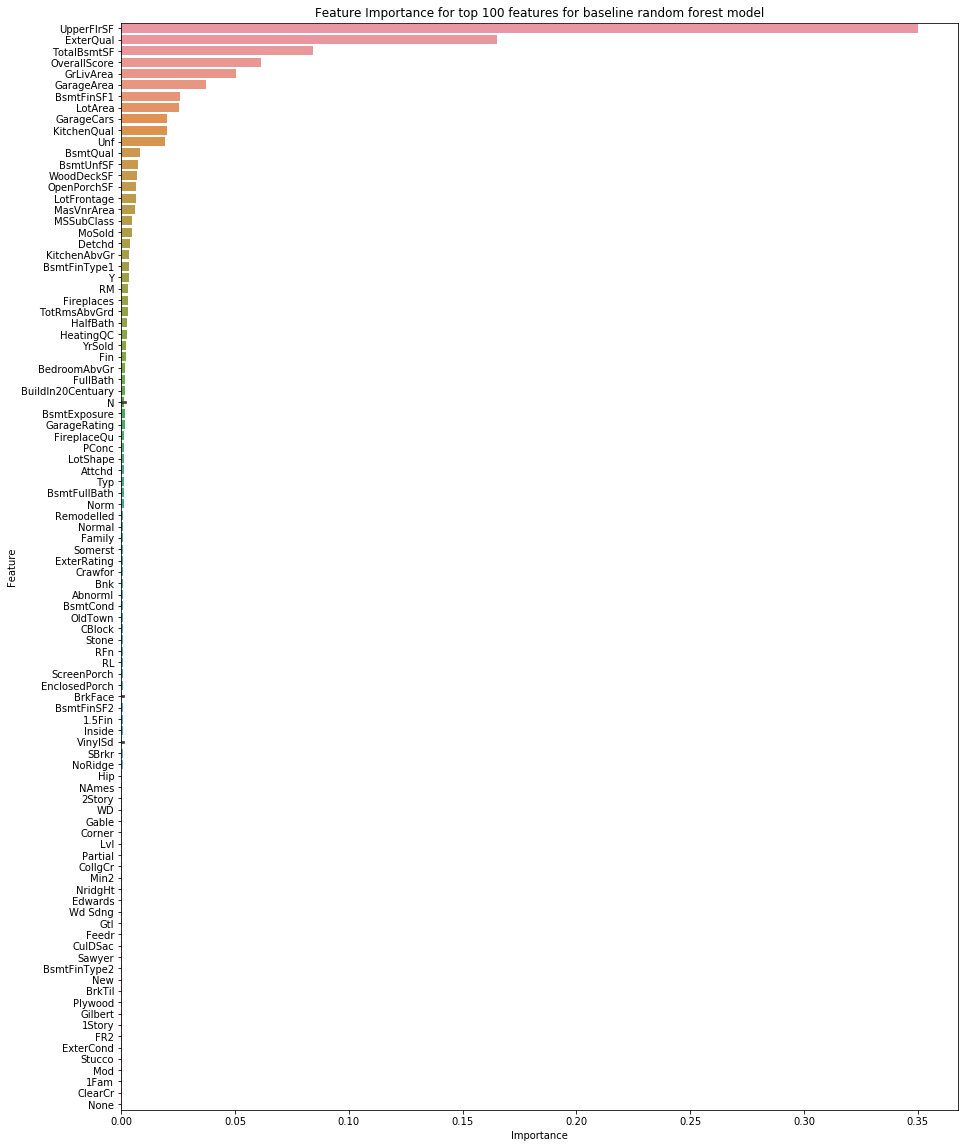

In [30]:
baseline_features_importance = rand_forest_baseline.feature_importances_
top_100_features_indices = np.argsort(baseline_features_importance)[::-1][:100]

plt.figure(figsize=(15, 20))
sns.barplot(baseline_features_importance[top_100_features_indices], baseline_features[top_100_features_indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for top 100 features for baseline random forest model')
plt.show()

Create a new random forest model based on the top 20 features

In [31]:
top_20_feature_indices = top_100_features_indices[:20]

X_train_top_20_features = X_train_processed[:, top_20_feature_indices]
X_train_top_20_features.shape

(981, 20)

In [32]:
rand_forest_top_20_features = RandomForestRegressor(random_state=RANDOM_STATE)
scores = cross_val_regression(rand_forest_top_20_features, X_train_top_20_features, y_train)

print('Random Forest Top 20 Features RMLSE: {:.3f}'.format(scores['rmlse']))
print('Random Forest Top 20 Features RMSE: {:.3f}'.format(scores['rmse']))

Random Forest Top 20 Features RMLSE: 0.147
Random Forest Top 20 Features RMSE: 22991.819


Results are more or less the same as the previous baseline, so we are seeing a significant improvement already compared to the original baseline.

Next I will try applying grid search to see if that can improve the performance of the model

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators': [100, 150, 200, 250, 300, 350, 400],
        'criterion': ['mse', 'mae'],
        'bootstrap': [True, False],
        'warm_start': [True, False]
    }
]

random_forest_v1 = RandomForestRegressor(random_state=RANDOM_STATE)
grid_search_v1 = GridSearchCV(random_forest_v1, param_grid, cv=3, n_jobs=2, verbose=2, scoring='neg_mean_squared_log_error')
grid_search_v1.fit(X_train_top_20_features, y_train)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   17.9s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Done 168 out of 168 | elapsed:  6.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [34]:
np.sqrt(-grid_search_v1.best_score_)

0.1465689666519611

In [35]:
grid_search_v1.best_params_

{'bootstrap': True,
 'criterion': 'mse',
 'n_estimators': 200,
 'warm_start': True}

In [36]:
best_model_v1 = grid_search_v1.best_estimator_
scores = cross_val_regression(best_model_v1, X_train_top_20_features, y_train)

print('Best Random Forest Top 20 Features RMLSE: {:.3f}'.format(scores['rmlse']))
print('Best Random Forest Top 20 Features RMSE: {:.3f}'.format(scores['rmse']))

Best Random Forest Top 20 Features RMLSE: 0.146
Best Random Forest Top 20 Features RMSE: 22892.590


From applying the grid search, we have only improved by a very minor result. Need to try other features to see if we can improve the final result

## Understanding the top 20 features

In [37]:
X_train_20_features = pd.DataFrame(X_train_top_20_features, columns=baseline_features[top_20_feature_indices])
X_train_20_features.head()

,UpperFlrSF,ExterQual,TotalBsmtSF,OverallScore,GrLivArea,GarageArea,BsmtFinSF1,LotArea,GarageCars,KitchenQual,Unf,BsmtQual,BsmtUnfSF,WoodDeckSF,OpenPorchSF,LotFrontage,MasVnrArea,MSSubClass,MoSold,Detchd
0,7.428333,3.0,7.173958,2.014903,7.428333,6.274762,0.000000,9.249657,1.098612,3.0,1.0,3.0,7.173958,4.595120,0.000000,4.394449,5.666427,3.044522,1.791759,0.0
1,6.978214,3.0,6.306275,1.791759,6.978214,6.265301,6.306275,8.209580,1.098612,3.0,0.0,2.0,0.000000,0.000000,3.367296,3.583519,4.394449,5.198497,1.791759,0.0
2,7.344719,3.0,6.629363,1.945910,7.344719,6.421622,3.218876,9.064274,1.098612,2.0,1.0,2.0,6.597146,5.135798,3.828641,4.290459,0.000000,4.110874,1.945910,0.0
3,7.552762,0.0,7.552762,2.079442,7.552762,6.670766,0.000000,9.364862,1.386294,0.0,0.0,0.0,7.552762,0.000000,5.257495,4.442651,5.713733,3.044522,1.386294,0.0
4,7.415777,2.0,6.684612,2.014903,7.415777,6.311735,5.955837,9.275004,1.098612,2.0,0.0,2.0,4.262680,5.068904,4.127134,3.784190,0.000000,4.110874,1.609438,0.0


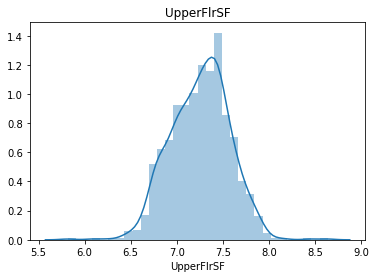

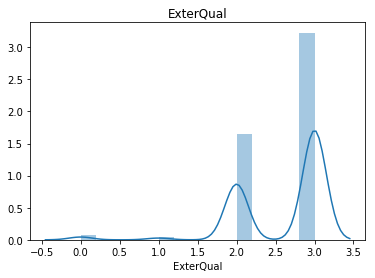

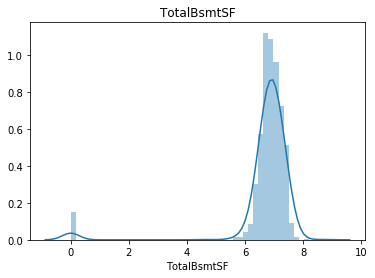

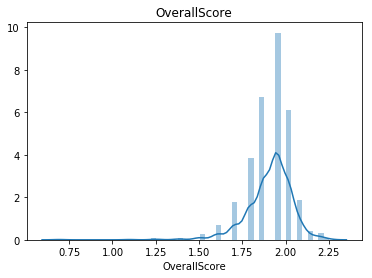

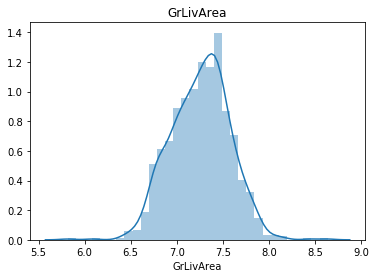

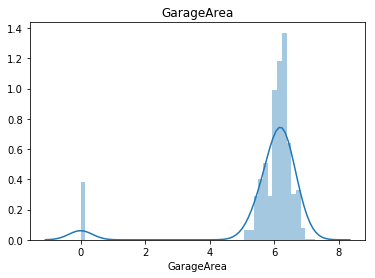

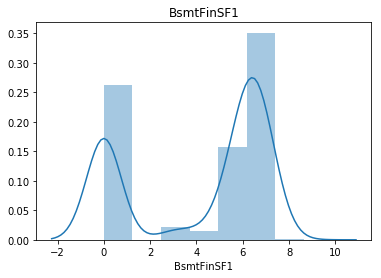

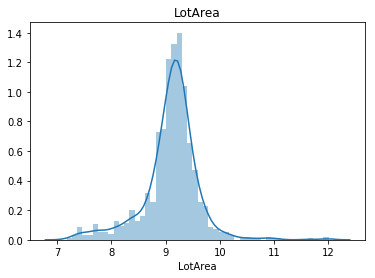

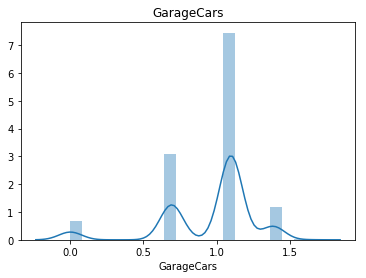

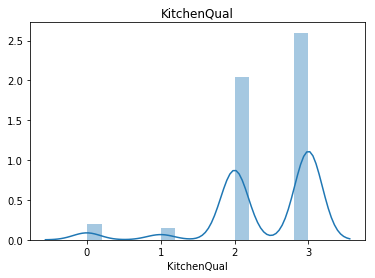

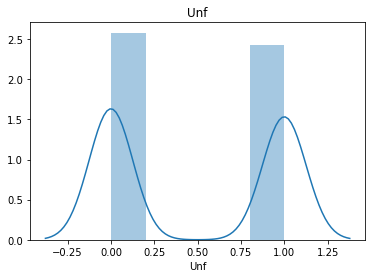

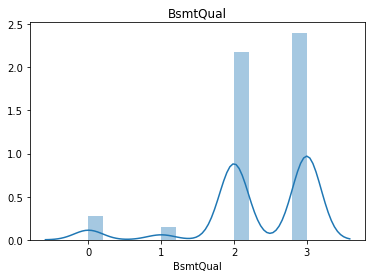

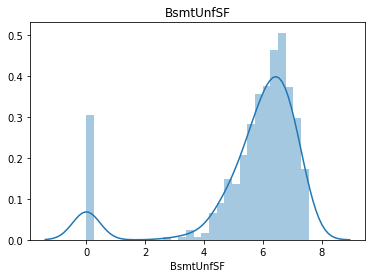

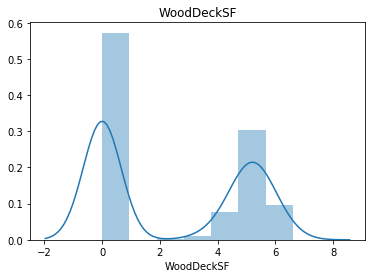

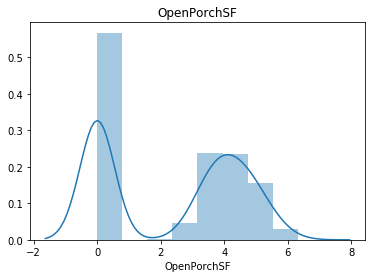

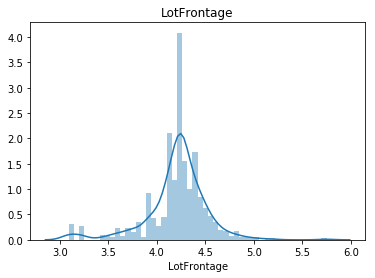

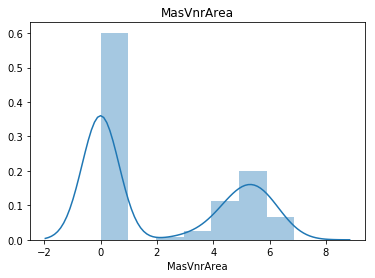

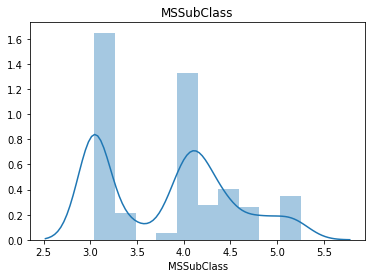

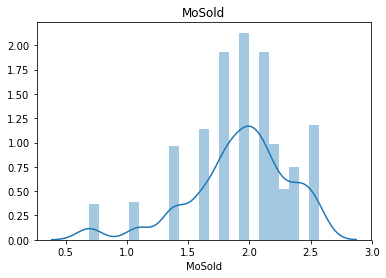

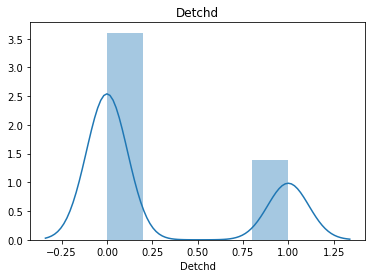

In [38]:
for c in X_train_20_features.columns:
    col_data = X_train_20_features[c]
    sns.distplot(col_data)
    plt.title(c)
    plt.show()

In [39]:
features = [
    'TotalBsmtSF',
    'GarageArea',
    'BsmtUnfSF'
]

def get_interquartile_range(data):
    q1, q3 = data.quantile([0.25, 0.75])
    iqr = q3 - q1
    
    max_v = q3 + 1.5 * iqr
    min_v = q1 - 1.5 * iqr
    return min_v, max_v

def remove_anomalies(data):
    min_v, max_v = get_interquartile_range(data)
    not_anomalies = (data > min_v) & (data < max_v)
    return data[not_anomalies].index

X_train_20_features_refined = X_train_20_features
y_train_refined = y_train
for f in features:
    feature_data = X_train_20_features_refined[f]
    idx = remove_anomalies(feature_data)
    X_train_20_features_refined = X_train_20_features_refined.iloc[idx]
    y_train_refined = y_train_refined.iloc[idx]
    X_train_20_features_refined.reset_index(drop=True, inplace=True)

In [40]:
rand_forest_v2 = RandomForestRegressor(random_state=RANDOM_STATE, **grid_search_v1.best_params_)
scores = cross_val_regression(rand_forest_v2, X_train_20_features_refined, y_train_refined)

In [41]:
print('Random Forest Top 20 Refined RMLSE: {:.3f}'.format(scores['rmlse']))
print('Random Forest Top 20 Refined RMSE: {:.3f}'.format(scores['rmse']))

Random Forest Top 20 Refined RMLSE: 0.136
Random Forest Top 20 Refined RMSE: 22723.054


Results so far have been pretty much the same with only very minor changes in error scores.

## Feature Engineering Pt2

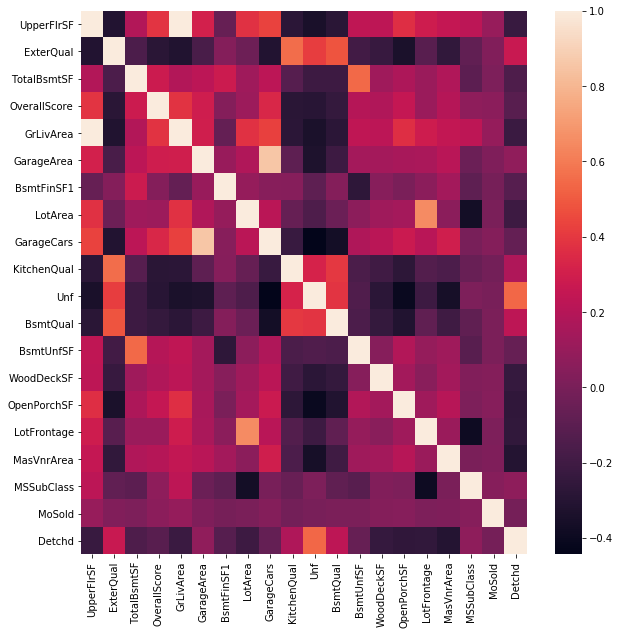

In [52]:
plt.figure(figsize=(10, 10))
sns.heatmap(X_train_20_features.corr())
plt.show()

From the correlation matrix of the 20 features used previosuly, we can see there is a strong correlation between `GrLivArea` and `UpperFlrSF`. We could turn this into a single feature

In [58]:
(X_train_20_features_refined.GrLivArea == X_train_20_features_refined.UpperFlrSF).value_counts()

True     833
False     11
dtype: int64

From looking at the data dictionary and the results, the engineered feature `UpperFlrSF` seems to be the same as `GrLivArea`. From this I could remove one of them.

In [66]:
numeric_cols_v2 = [
     'MSSubClass',
     'LotFrontage',
     'LotArea',
     'MasVnrArea',
     'BsmtFinSF1',
     'BsmtFinSF2',
     'BsmtUnfSF',
     'TotalBsmtSF',
     'LowQualFinSF',
     'BsmtFullBath',
     'BsmtHalfBath',
     'FullBath',
     'HalfBath',
     'BedroomAbvGr',
     'KitchenAbvGr',
     'TotRmsAbvGrd',
     'Fireplaces',
     'GarageCars',
     'GarageArea',
     'WoodDeckSF',
     'OpenPorchSF',
     'EnclosedPorch',
     '3SsnPorch',
     'ScreenPorch',
     'PoolArea',
     'MiscVal',
     'MoSold',
     'YrSold',
     'OverallScore',
     'UpperFlrSF',
     'GarageRating',
     'ExterRating',
     'BuildIn20Centuary',
     'Remodelled'
]

ordinal_cols_v2 = [
    'LotShape',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'HeatingQC',
    'KitchenQual',
    'FireplaceQu'
]

categorical_cols_v2 = [
    'MSZoning',
    'Street',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st', 
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'CentralAir',
    'Electrical',
    'Functional',
    'GarageType',
    'GarageFinish',
    'PavedDrive',
    'SaleType',
    'SaleCondition'
]

In [67]:
numeric_pipeline_v2 = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p))
])

ordinal_pipeline_v2 = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

categorical_pipeline_v2 = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

processing_pipeline_v2 = Pipeline([
    ('numeric_features', CreateNumericFeatures()),
    ('garage', CombineGarageFeatures()),
    ('extorior', ExteriorCondition()),
    ('processing', ColumnTransformer([
        ('numeric', numeric_pipeline, numeric_cols_v2),
        ('ordinal', ordinal_pipeline, ordinal_cols_v2),
        ('categorical', categorical_pipeline, categorical_cols_v2)
    ]))
])

In [68]:
X_train_processed_v2 = processing_pipeline_v2.fit_transform(X_train_df)

In [70]:
rand_forest_v3 = RandomForestRegressor(random_state=RANDOM_STATE, **grid_search_v1.best_params_)
scores = cross_val_regression(rand_forest_v3, X_train_processed_v2, y_train, cv=3)

In [75]:
scores

{'rmlse': 0.14257614749010586, 'rmse': 22725.70455996513}

In [72]:
rand_forest_v3.fit(X_train_processed_v2, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=True)

In [85]:
feature_importance = rand_forest_v3.feature_importances_
importance_sorted = np.argsort(feature_importance)[::-1]

feature_cols = np.concatenate(processing_pipeline_v2['processing'].transformers_[2][1]['one_hot'].categories_)
feature_cols = np.concatenate([numeric_cols_v2, ordinal_cols_v2, feature_cols])
key_cols = feature_cols[importance_sorted][:20]
key_cols

array(['UpperFlrSF', 'TotalBsmtSF', 'KitchenQual', 'OverallScore',
       'GarageArea', 'Unf', 'GarageCars', 'LotArea', 'BsmtFinSF1',
       'BsmtQual', 'ExterRating', 'OpenPorchSF', 'MasVnrArea',
       'BsmtUnfSF', 'WoodDeckSF', 'LotFrontage', 'Fireplaces', 'MoSold',
       'PConc', 'BuildIn20Centuary'], dtype=object)

In [91]:
X_train_top_20_features = X_train_processed_v2[:, importance_sorted[:20]]

(981, 20)

In [92]:
rand_forest_v4 = RandomForestRegressor(random_state=RANDOM_STATE, **grid_search_v1.best_params_)
scores = cross_val_regression(rand_forest_v4, X_train_top_20_features, y_train, cv=3)
scores

{'rmlse': 0.14476862833605594, 'rmse': 23122.987553925093}

## Applying PCA to all the features

In [102]:
from sklearn.decomposition import PCA

pca = PCA(random_state=RANDOM_STATE, n_components=0.95)
X_train_pca = pca.fit_transform(X_train_processed_v2)

In [103]:
X_train_pca = pca.fit_transform(X_train_processed_v2)cross_val_regression(rand_forest_v4, , y_train, cv=3)

{'rmlse': 0.20718932864830011, 'rmse': 34569.72217661111}

Compared to previous runs, applying random forest and extracting the relevant indices seems to yeild the best results

In [106]:
selected_indices = importance_sorted[:20]

In [109]:
class IndexSelector(TransformerMixin):
    def __init__(self, idxs):
        self.idxs = idxs
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[:, self.idxs]

In [185]:
numeric_pipeline_v3 = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p))
])

ordinal_pipeline_v3 = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

categorical_pipeline_v3 = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

processing_pipeline_v3 = Pipeline([
    ('numeric_features', CreateNumericFeatures()),
    ('garage', CombineGarageFeatures()),
    ('extorior', ExteriorCondition()),
    ('processing', ColumnTransformer([
        ('numeric', numeric_pipeline, numeric_cols_v2),
        ('ordinal', ordinal_pipeline, ordinal_cols_v2),
        ('categorical', categorical_pipeline, categorical_cols_v2)
    ])),
    ('idx', IndexSelector(selected_indices)),
    ('ml', RandomForestRegressor(random_state=RANDOM_STATE, bootstrap=True, criterion='mse', n_estimators=200))
])

In [186]:
processing_pipeline_v3 = processing_pipeline_v3.fit(X_train_df, y_train)

In [187]:
y_pred = processing_pipeline_v3.predict(X_train_df)

rmsle = root_mean_log_error(y_train, y_pred)
rmse = root_mean_squared_error(y_train, y_pred)
print('Final Training RMSLE: {:.3f}'.format(rmsle))
print('Final Training RMSE: {:.3f}'.format(rmse))

Final Training RMSLE: 0.056
Final Training RMSE: 8513.418


## Saving the best model

In [190]:
base_numeric_cols = [
     'MSSubClass',
     'LotFrontage',
     'LotArea',
     'MasVnrArea',
     'BsmtFinSF1',
     'BsmtFinSF2',
     'BsmtUnfSF',
     'TotalBsmtSF',
     'LowQualFinSF',
     'BsmtFullBath',
     'BsmtHalfBath',
     'FullBath',
     'HalfBath',
     'BedroomAbvGr',
     'KitchenAbvGr',
     'TotRmsAbvGrd',
     'Fireplaces',
     'GarageCars',
     'GarageArea',
     'WoodDeckSF',
     'OpenPorchSF',
     'EnclosedPorch',
     '3SsnPorch',
     'ScreenPorch',
     'PoolArea',
     'MiscVal',
     'MoSold',
     'YrSold',
     'OverallQual',
     'OverallCond',
     '1stFlrSF',
     '2ndFlrSF',
     'GarageYrBlt',
     'YearBuilt',
     'YearRemodAdd'
]

base_ordinal_cols = [
    'LotShape',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'HeatingQC',
    'KitchenQual',
    'FireplaceQu',
    'GarageQual',
    'GarageCond',
    'ExterQual',
    'ExterCond'
]

base_categorical_cols = [
    'MSZoning',
    'Street',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st', 
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'CentralAir',
    'Electrical',
    'Functional',
    'GarageType',
    'GarageFinish',
    'PavedDrive',
    'SaleType',
    'SaleCondition'
]

In [193]:
from datetime import datetime

all_cols = base_numeric_cols + base_ordinal_cols + base_categorical_cols

# model_title = "house_prices_model_v2_{}.joblib"

v = X_test[all_cols]
processing_pipeline_v3.predict(v)


c:\users\ryan\documents\development\data science\ml-house-prices\env\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\ryan\documents\development\data science\ml-house-prices\env\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
c:\users\ryan\documents\development\data science\ml-house-prices\env\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying 

ValueError: Number of features of the input must be equal to or greater than that of the fitted transformer. Transformer n_features is 82 and input n_features is 81.